### <center>COMPUTATIONAL METHODS IN FINANCE - MGMTMFE 405</center>
### <center>Project - 2</center>
#### <center>Akhil Srivastava</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon
from scipy.stats import norm
import time
import statsmodels.api as sm

Value of American Put Option with S0 = 180, X = 180, r = 5.5%, **T = 0.5** and sigma = 25% computed using CBOE option price calculator is 10.693.

Value of American Put Option with S0 = 180, X = 180, r = 5.5%, **T = 1.5** and sigma = 25% computed using CBOE option price calculator is 16.292.

These values will be used as benchmark to assess the error genereted by methods in this implementation.

## Question 1

In [2]:
# Binomial Tree Model for Pricing American Put Options
def BTAP(S0, X, r, T, n, u, d, p):
    # If T = 0 return today's excercise price
    if T == 0:
        return max(0, X - S0)

    Δ = T/n    
    df = np.exp(-r*Δ)
    
    # define: 'level' as distance from the root node, which ranges between 0 and n
    # the root is at 0th level while the leaves at the nth level
    # kth level has k+1 nodes
    # define: ud = (n_u, n_d), where n_u/d is the number of up/down moves it took to reach to a node from the root
    # ud values at kth value (top to bottom) = [(k, 0), (k-1, 1), ......., (0, k)]
    
    # array to store option value at each node for a level
    # value at the highest node is stored at index 0 and moving right in the array means going down the level    
    # the maximum number of the nodes are at the nth level (leaves' level), which has n+1 nodes
    option_vals = np.zeros(n+1)
    
    # initialize option values at nth level (leaves' level) with the excercise values
    level = n
    #print("level:", level)
    for i in range(level+1):
        # ud values at kth value (top to bottom) = [(k, 0), (k-1, 1), ......., (0, k)]
        stock_price = S0*u**(level-i)*d**i
        excercise_value = max(0, X - stock_price)
        option_vals[i] = excercise_value
        #print(option_vals[i])
    
    # starting with (n-1)th level, iterate each level of the tree until 0th level i.e. the root
    for level in range(n-1, -1, -1):
        #print("level:", level)
        # traverse a given level from top to bottom
        for i in range(level+1):
            stock_price = S0*u**(level-i)*d**i
            excercise_value = max(0, X - stock_price)
            payoff = (p*option_vals[i] + (1-p)*option_vals[i+1])*df
            option_vals[i] = max(excercise_value, payoff)
            #print(option_vals[i])
            
    return option_vals[0]

In [3]:
S0 = 180
X = 180
r = 5.5/100
T = 0.5
sigma = 25/100

n_vals = [20, 40, 80, 100, 200, 500]

**Part a**

In [4]:
def BTAP_1a(S0, X, r, T, sigma, n):
    Δ = T/n
    c = 0.5*(np.exp(-r*Δ) + np.exp((r+sigma**2)*Δ))
    d = c - np.sqrt(c**2 - 1)
    u = 1/d
    p = (np.exp(r*Δ) - d)/(u-d)
    return BTAP(S0, X, r, T, n, u, d, p)

In [5]:
put_vals_1a = np.zeros(len(n_vals))

for i in range(len(n_vals)):
    put_vals_1a[i] = BTAP_1a(S0, X, r, T, sigma, n_vals[i])

**Part b**

In [6]:
def BTAP_1b(S0, X, r, T, sigma, n):
    Δ = T/n
    u = np.exp((r-sigma**2/2)*Δ+sigma*np.sqrt(Δ))
    d = np.exp((r-sigma**2/2)*Δ-sigma*np.sqrt(Δ))    
    p = 1/2
    return BTAP(S0, X, r, T, n, u, d, p)

In [7]:
put_vals_1b = np.zeros(len(n_vals))

for i in range(len(n_vals)):
    put_vals_1b[i] = BTAP_1b(S0, X, r, T, sigma, n_vals[i])

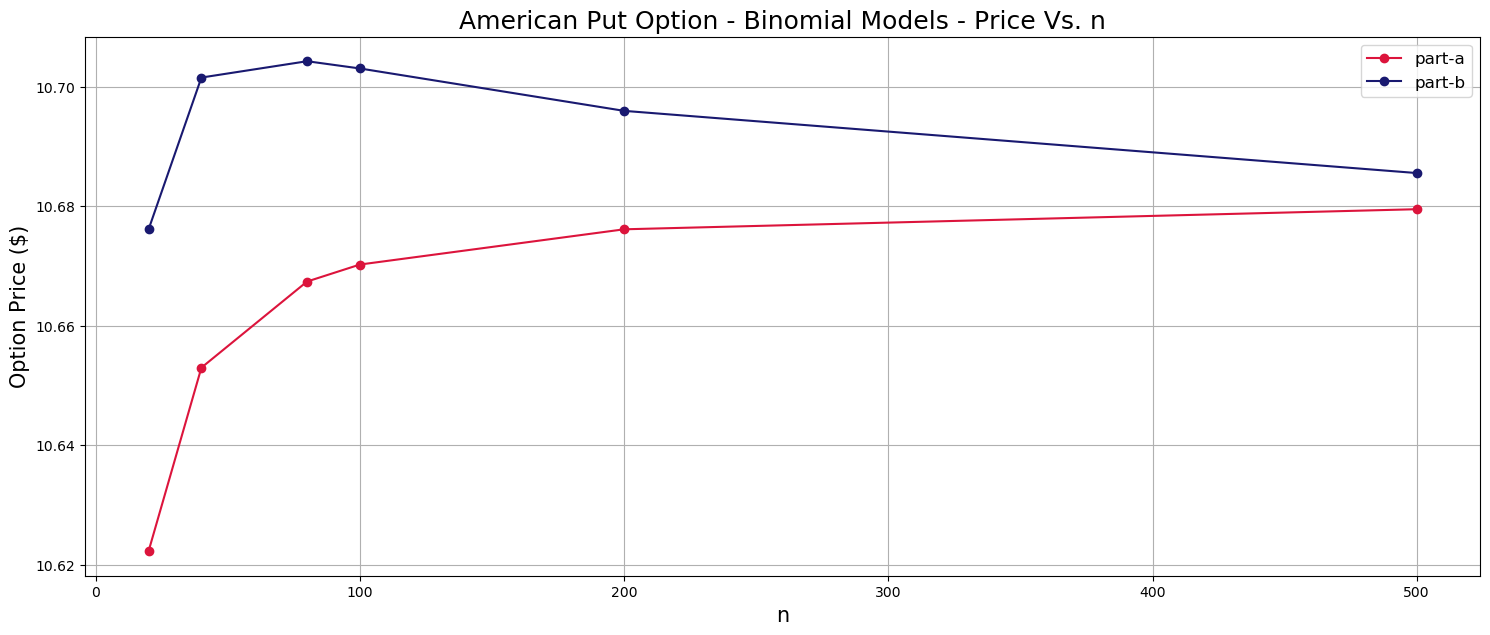

In [8]:
# Plot price Vs. n
plt.figure(figsize=(18, 7))
plt.plot(n_vals, put_vals_1a, "-o", color="crimson", label="part-a")
plt.plot(n_vals, put_vals_1b, "-o", color="midnightblue", label="part-b")
plt.title("American Put Option - Binomial Models - Price Vs. n", fontsize=18)
plt.xlabel("n", fontsize=15)
plt.ylabel("Option Price ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

## Question 2

In [9]:
def BTAP_CRR(S0, X, r, T, sigma, n):
    Δ = T/n
    u = np.exp(sigma*np.sqrt(Δ))
    d = np.exp(-sigma*np.sqrt(Δ))
    p = (np.exp(r*Δ) - d)/(u-d)
    return BTAP(S0, X, r, T, n, u, d, p)

In [10]:
# Estimates delta and vega of an American Put option using the CRR Binomial tree method
def BTAP_CRR_Greeks1(S0, X, r, T, sigma, n=500, epsilon=0.01):
    ap_plus = BTAP_CRR(S0*(1+epsilon), X, r, T, sigma, n)
    ap_minus = BTAP_CRR(S0*(1-epsilon), X, r, T, sigma, n)
    ap_delta = (ap_plus - ap_minus)/(2*epsilon*S0)

    ap_plus = BTAP_CRR(S0, X, r, T, sigma*(1+epsilon), n)
    ap_minus = BTAP_CRR(S0, X, r, T, sigma*(1-epsilon), n)
    ap_vega = (ap_plus - ap_minus)/(2*epsilon*sigma)

    return ap_delta, ap_vega

In [11]:
# Estimates delta and theta of an American Put option using the CRR Binomial tree method
def BTAP_CRR_Greeks2(S0, X, r, T, sigma, n=500, epsilon=0.01):
    ap_plus = BTAP_CRR(S0*(1+epsilon), X, r, T, sigma, n)
    ap_minus = BTAP_CRR(S0*(1-epsilon), X, r, T, sigma, n)
    ap_delta = (ap_plus - ap_minus)/(2*epsilon*S0)

    ap_plus = BTAP_CRR(S0, X, r, T*(1+epsilon), sigma, n)
    ap_minus = BTAP_CRR(S0, X, r, T*(1-epsilon), sigma, n)
    ap_theta = -(ap_plus - ap_minus)/(2*epsilon*T)

    return ap_delta, ap_theta

In [12]:
# Estimate the American Put option’s greeks

S0 = 180
X = 180
r = 0.055
T = 0.5
sigma = 0.25

n = 500
epsilon = 0.01

S0_vals = np.arange(170, 191, 2)
T_vals = np.arange(0.003, 0.18+0.003, 0.003)

df_greeks_S0 = pd.DataFrame(index=S0_vals, columns=['Delta', 'Vega'])
df_greeks_T = pd.DataFrame(index=T_vals, columns=['Delta', 'Theta'])

for S0_ in S0_vals:
    df_greeks_S0.loc[[S0_]] = BTAP_CRR_Greeks1(S0_, X, r, T, sigma, n, epsilon)
    
for T_ in T_vals:
    df_greeks_T.loc[[T_]] = BTAP_CRR_Greeks2(S0, X, r, T_, sigma, n, epsilon)

In [13]:
pd.set_option("display.precision", 6)
print("Estimated American Put option’s greeks:")
display(df_greeks_S0)

Estimated American Put option’s greeks:


,Delta,Vega
170,-0.576355,45.827486
172,-0.544702,47.205058
174,-0.513563,47.681546
176,-0.484554,48.574032
178,-0.45866,49.049523
180,-0.429539,49.127235
182,-0.401504,49.126249
184,-0.379361,48.736951
186,-0.353177,48.008599
188,-0.32792,47.774461


In [14]:
print("Estimated American Put option’s greeks:")
display(df_greeks_T)

Estimated American Put option’s greeks:


,Delta,Theta
0.003,-0.494628,-159.387802
0.006,-0.49164,-111.451081
0.009,-0.489532,-90.222045
0.012,-0.487923,-77.57141
0.015,-0.486307,-68.9415
0.018,-0.485042,-62.573501
0.021,-0.483885,-57.625441
0.024,-0.482592,-53.63728
0.027,-0.481573,-50.335364
0.030,-0.480624,-47.542731


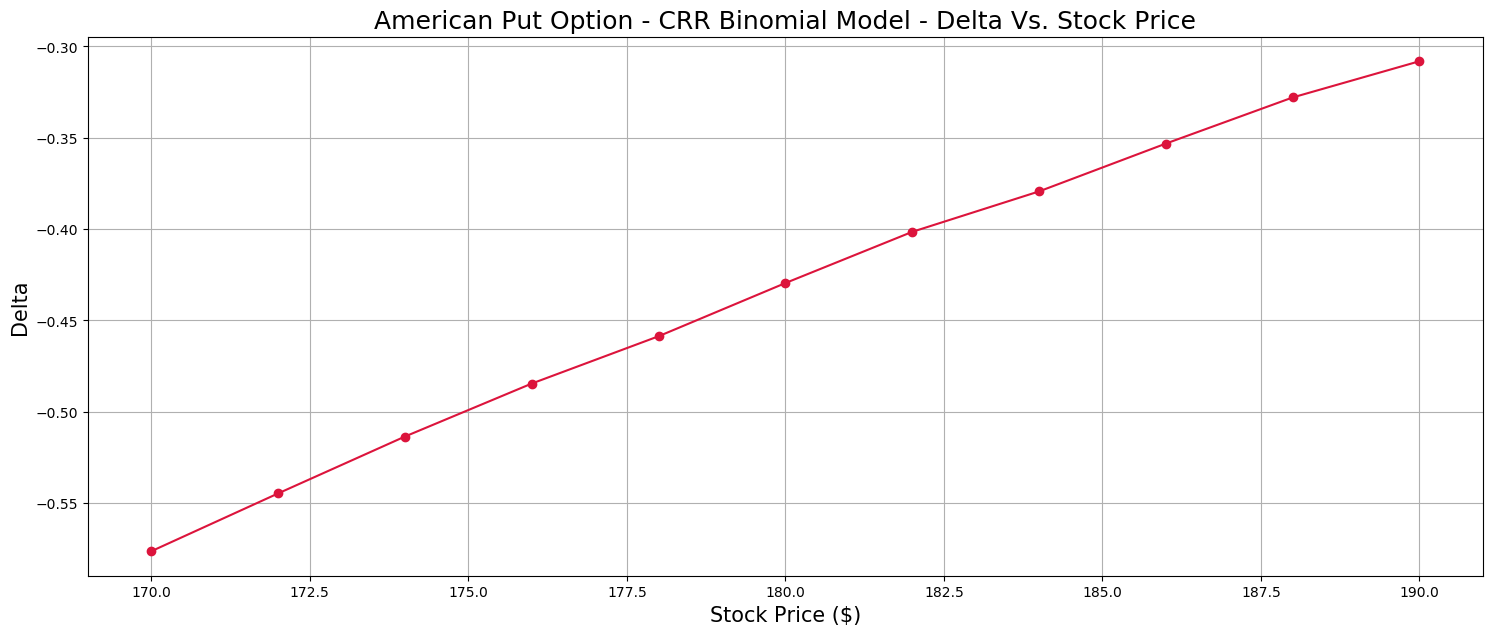

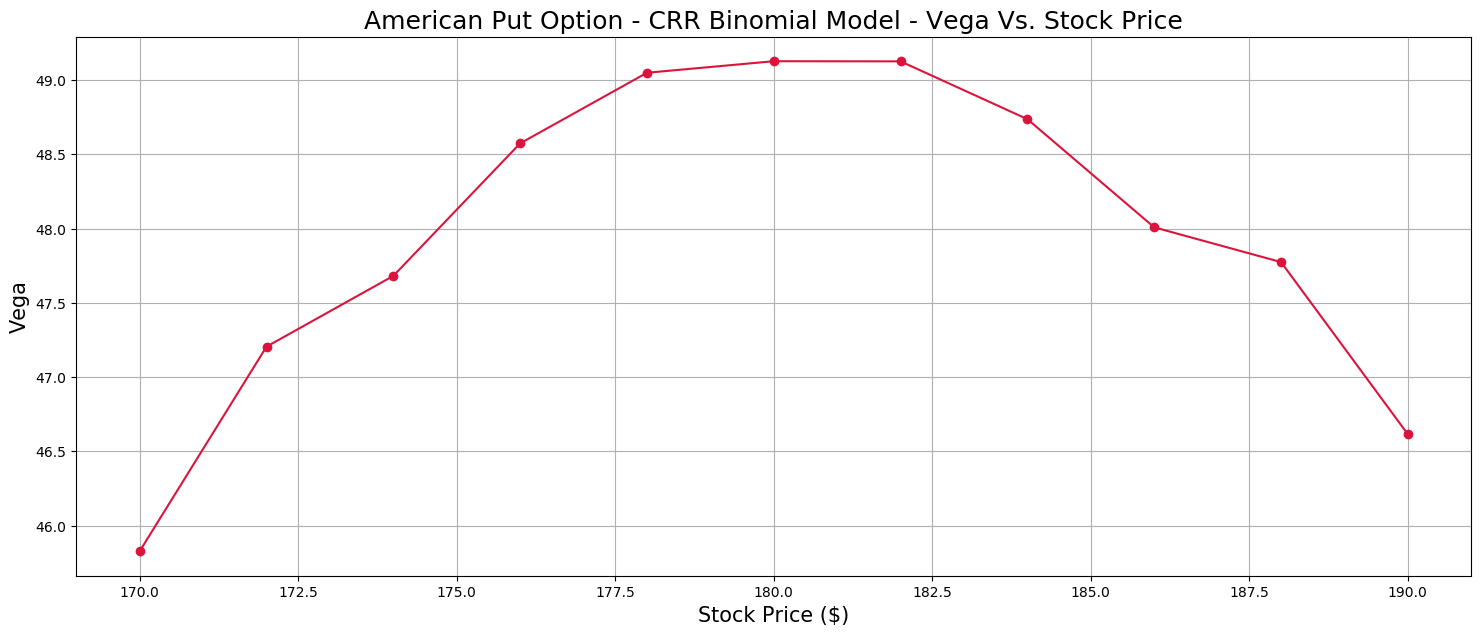

In [15]:
# Plot Greek Values Vs. Stock Price
for i in range(len(df_greeks_S0.columns)):
    plt.figure(figsize=(18, 7))
    plt.plot(S0_vals, df_greeks_S0.iloc[:, i].values, "-o", color='crimson')
    plt.title("American Put Option - CRR Binomial Model - " + df_greeks_S0.columns[i] + " Vs. Stock Price", fontsize=18)
    plt.xlabel("Stock Price ($)", fontsize=15)
    plt.ylabel(df_greeks_S0.columns[i], fontsize=15)
    plt.grid(True)
    plt.show();

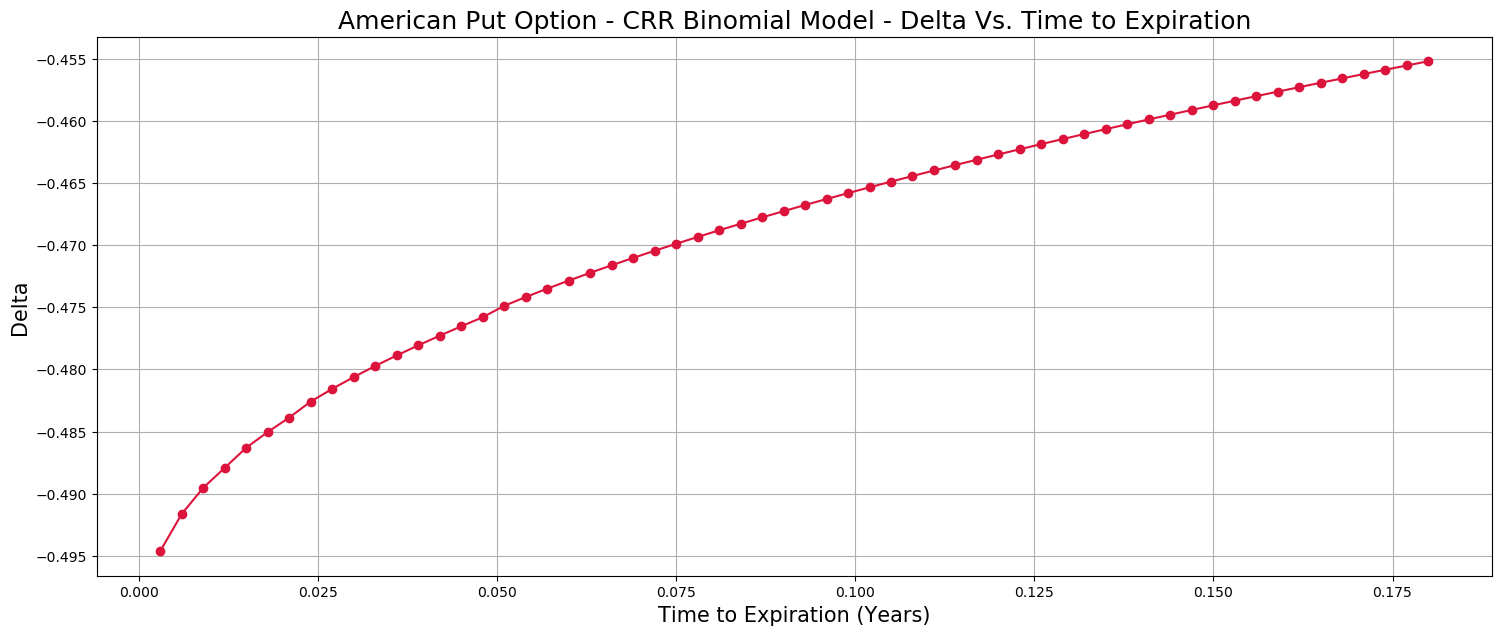

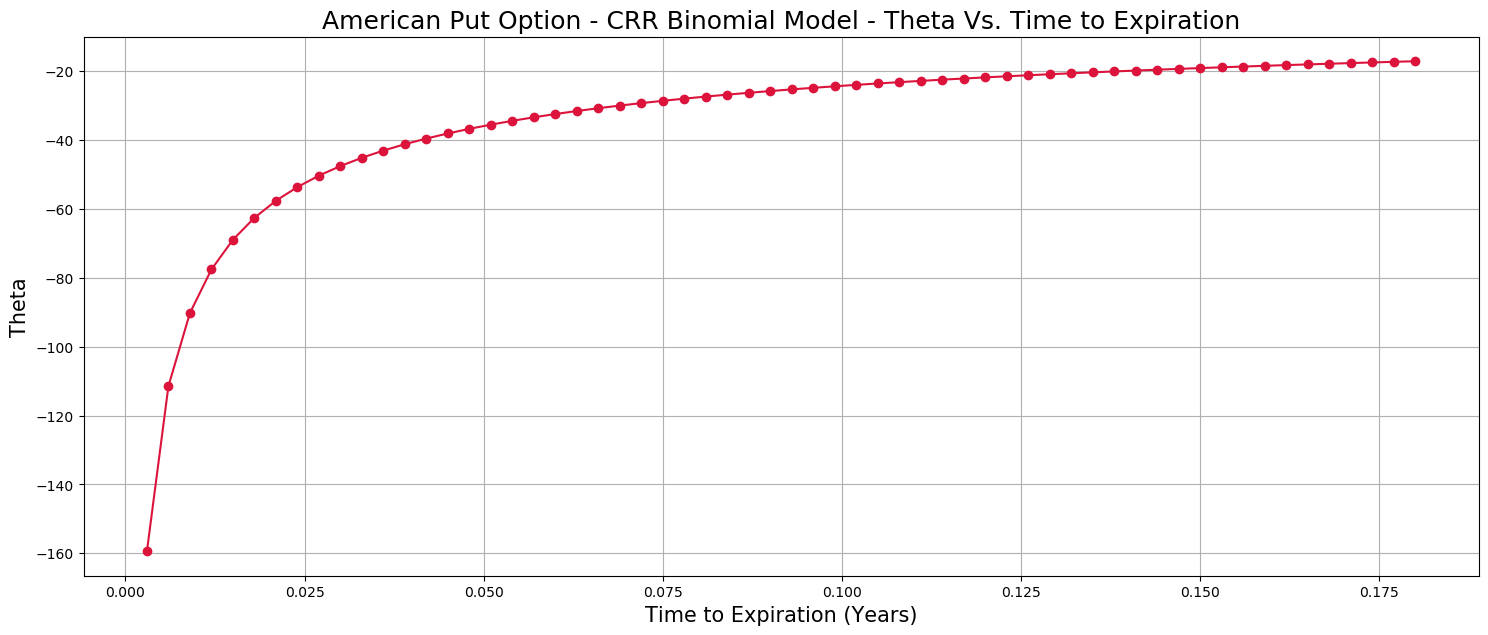

In [16]:
# Plot Greek Values Vs. T
for i in range(len(df_greeks_T.columns)):
    plt.figure(figsize=(18, 7))
    plt.plot(T_vals, df_greeks_T.iloc[:, i].values, "-o", color='crimson')
    plt.title("American Put Option - CRR Binomial Model - " + df_greeks_T.columns[i] + " Vs. Time to Expiration",
              fontsize=18)
    plt.xlabel("Time to Expiration (Years)", fontsize=15)
    plt.ylabel(df_greeks_T.columns[i], fontsize=15)
    plt.grid(True)
    plt.show();

## Question 3

In [17]:
# Trinomial Tree Model for Pricing American Put Options
def TTAP(S0, X, r, T, n, u, d, pu, pd, log_price=False):
    # If T = 0 return today's excercise price
    if T == 0:
        return max(0, X - S0)

    Δ = T/n    
    df = np.exp(-r*Δ)
    
    # define: 'level' as distance from the root node, which ranges between 0 and n
    # the root is at 0th level while the leaves at the nth level
    # kth level has 2k+1 nodes
    # define: ud = (n_u, n_d), where n_u/d is the number of up/down moves it took to reach to a node from the root
    # ud values at kth value (top to bottom) = [(k, 0), (k-1, 0), (k-1, 1), ......., (0, k)]
    
    # array to store option value at each node for a level
    # value at the highest node is stored at index 0 and moving right in the array means going down the level    
    # the maximum number of the nodes are at the nth level (leaves' level), which has 2n+1 nodes
    option_vals = np.zeros(2*n+1)
    
    # initialize option values at nth level (leaves' level) with the excercise values
    level = n
    for i in range(2*level+1):
        # ud values at kth value (top to bottom) = [(k, 0), (k-1, 0), (k-1, 1), ......., (0, k)]
        if log_price == True:
            log_stock_price = np.log(S0) + u*(level-int((i+1)/2)) + d*(int(i/2))
            stock_price = np.exp(log_stock_price)
        else:
            stock_price = S0*u**(level-int((i+1)/2))*d**(int(i/2))
        excercise_value = max(0, X - stock_price)
        option_vals[i] = excercise_value        
    
    # starting with (n-1)th level, iterate each level of the tree until 0th level i.e. the root
    for level in range(n-1, -1, -1):        
        # traverse a given level from top to bottom
        for i in range(2*level+1):
            if log_price == True:
                log_stock_price = np.log(S0) + u*(level-int((i+1)/2)) + d*(int(i/2))
                stock_price = np.exp(log_stock_price)
            else:
                stock_price = S0*u**(level-int((i+1)/2))*d**(int(i/2))
            excercise_value = max(0, X - stock_price)
            payoff = (pu*option_vals[i] + (1-pu-pd)*option_vals[i+1] + pd*option_vals[i+2])*df
            option_vals[i] = max(excercise_value, payoff)            
    return option_vals[0]

In [18]:
S0 = 180
X = 180
r = 5.5/100
T = 0.5
sigma = 25/100

n_vals = [20, 40, 70, 80, 100, 200, 500]

**Part a**

In [19]:
def TTAP_3a(S0, X, r, T, sigma, n):
    Δ = T/n
    d = np.exp(-sigma*np.sqrt(3*Δ))
    u = 1/d
    pd = (r*Δ*(1-u) + (r*Δ)**2 + sigma**2*Δ)/((u-d)*(1-d))
    pu = (r*Δ*(1-d) + (r*Δ)**2 + sigma**2*Δ)/((u-d)*(u-1))
    return TTAP(S0, X, r, T, n, u, d, pu, pd)

In [20]:
put_vals_3a = np.zeros(len(n_vals))

for i in range(len(n_vals)):
    put_vals_3a[i] = TTAP_3a(S0, X, r, T, sigma, n_vals[i])

**Part b**

In [21]:
def TTAP_3b(S0, X, r, T, sigma, n):
    Δ = T/n
    ΔXd = -sigma*np.sqrt(3*Δ)
    ΔXu = sigma*np.sqrt(3*Δ)
    pd = 0.5*((sigma**2*Δ + (r-sigma**2/2)**2*Δ**2)/ΔXu**2 - (r-sigma**2/2)*Δ/ΔXu)
    pu = 0.5*((sigma**2*Δ + (r-sigma**2/2)**2*Δ**2)/ΔXu**2 + (r-sigma**2/2)*Δ/ΔXu)
    return TTAP(S0, X, r, T, n, ΔXu, ΔXd, pu, pd, True)

In [22]:
put_vals_3b = np.zeros(len(n_vals))

for i in range(len(n_vals)):
    put_vals_3b[i] = TTAP_3b(S0, X, r, T, sigma, n_vals[i])

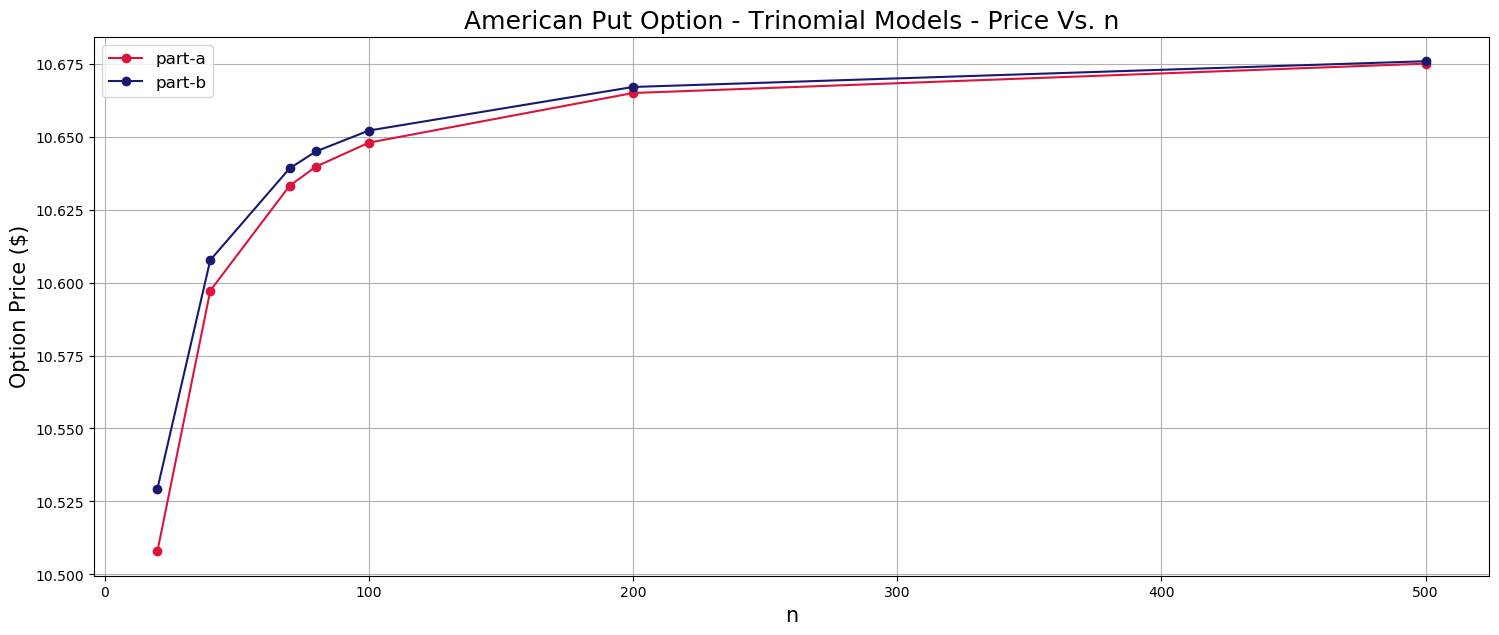

In [23]:
# Plot price Vs. n
plt.figure(figsize=(18, 7))
plt.plot(n_vals, put_vals_3a, "-o", color="crimson", label="part-a")
plt.plot(n_vals, put_vals_3b, "-o", color="midnightblue", label="part-b")
plt.title("American Put Option - Trinomial Models - Price Vs. n", fontsize=18)
plt.xlabel("n", fontsize=15)
plt.ylabel("Option Price ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

## Question 4

In [24]:
# Simulates N GBM paths of 𝑆𝑡 for [0, t] by dividing up the interval [0, t] into size of Δ
def GBM_Paths(S0, r, t, sigma, N=10000, seed=42):
    Δ = 1/np.sqrt(N)
    n_columns= int(t/Δ)
    St_paths = np.zeros((N, n_columns))
    
    np.random.seed(seed)
    n_rows = int(N/2)
    z = np.random.normal(0, 1, n_rows*n_columns).reshape((n_rows, n_columns))
    
    for i in range(n_rows):
        St_paths[2*i, :] = np.exp((r-sigma**2/2)*Δ + sigma*Δ**0.5*z[i, :])
        St_paths[2*i+1, :] = np.exp((r-sigma**2/2)*Δ - sigma*Δ**0.5*z[i, :])
    return S0*St_paths.cumprod(axis=1)

In [25]:
def compute_ECV(x, y, method, k):
    poly_x = method(x, k)

    # Create and fit the model
    model_fit = sm.OLS(y, poly_x).fit()

    # Return predicted value
    return model_fit.predict(poly_x)

In [26]:
def AP_LSMC(S0, X, r, T, sigma, method, k=2, N=10000, seed=42):
    Δ = 1/np.sqrt(N)
    
    # Create GBM Paths
    St = GBM_Paths(S0, r, T, sigma, N, seed)
    option_val = (X - St[:, -1]).clip(min=0)    
    
    for j in range(St.shape[1]-2, -1, -1):
        EV = (X - St[:, j]).clip(min=0)
        option_val = np.exp(-r*Δ)*option_val
        itm_indices = np.where(EV > 0)[0]
        ECV = np.tile(np.inf, St.shape[0])        
        ECV[itm_indices] = compute_ECV(St[itm_indices, j], option_val[itm_indices], method, k)        
        ex_indices = np.where(EV > ECV)[0]        
        option_val[ex_indices] = EV[ex_indices]
        
    return np.exp(-r*Δ)*option_val.mean()

In [27]:
N = 100000
seed = 42

S0 = 180
X = 180
r = 5.5/100
sigma = 25/100

T_vals = [0.5, 1.5]
k_vals = [2, 3, 4, 5]

df_q4 = pd.DataFrame()
df_q4["k"] = k_vals

**Part a**

In [28]:
def laguerre_polynomial(x, k):
    poly_x = np.zeros(((x.shape[0], k)))

    if k >= 1:
        poly_x[:, 0] = 1
    else:
        return poly_x
    
    if k >= 2:
        poly_x[:, 1] = (1 - x)
    else:
        return poly_x
    
    if k >= 3:
        poly_x[:, 2] = (1 - 2*x + x**2/2)
    else:
        return poly_x
    
    if k >= 4:
        poly_x[:, 3] = (1 - 3*x + 3*x**2/2 - x**3/6)
    else:
        return poly_x
    
    if k >= 5:
        poly_x[:, 4] = (1 - 4*x + 3*x**2 - 2*x**3/3 + x**4/24)
    else:
        return poly_x
    
    if k >= 6:
        print("Error! k should be less than 6!")
        return None
    else:
        return poly_x

In [29]:
for T in (T_vals):
    for i in range(len(k_vals)):
        df_q4.loc[i, "Laguerre [T=" + str(T) + "]"] = AP_LSMC(S0, X, r, T, sigma, laguerre_polynomial, k_vals[i], N, seed)

In [30]:
df_q4

,k,Laguerre [T=0.5],Laguerre [T=1.5]
0,2,10.462588,15.885117
1,3,10.584695,16.157106
2,4,10.635882,16.213299
3,5,10.635252,16.228553


Comment - As we are increasing the value of 'k' option pricing error improves until k = 4 for both the options but when k is changed from 4 to 5, there is some improvment for T = 1.5 but it slightly degrades for T = 0.5.

**Part b**

In [31]:
def hermite_polynomial(x, k):
    poly_x = np.zeros(((x.shape[0], k)))

    if k >= 1:
        poly_x[:, 0] = 1
    else:
        return poly_x
    
    if k >= 2:
        poly_x[:, 1] = 2*x
    else:
        return poly_x
    
    if k >= 3:
        poly_x[:, 2] = 4*x**2 - 2
    else:
        return poly_x
    
    if k >= 4:
        poly_x[:, 3] = 8*x**3 - 12*x
    else:
        return poly_x
    
    if k >= 5:
        poly_x[:, 4] = 16*x**4 - 56*x**2 + 16
    else:
        return poly_x
    
    if k >= 6:
        print("Error! k should be less than 6!")
        return None
    else:
        return poly_x

In [32]:
for T in (T_vals):
    for i in range(len(k_vals)):
        df_q4.loc[i, "Hermite [T=" + str(T) + "]"] = AP_LSMC(S0, X, r, T, sigma, hermite_polynomial, k_vals[i], N, seed)

In [33]:
df_q4

,k,Laguerre [T=0.5],Laguerre [T=1.5],Hermite [T=0.5],Hermite [T=1.5]
0,2,10.462588,15.885117,10.462588,15.885117
1,3,10.584695,16.157106,10.584695,16.157106
2,4,10.635882,16.213299,10.635882,16.213299
3,5,10.635252,16.228553,10.637083,16.226026


Comment - As we are increasing the value of 'k' option pricing error improves until k = 4 for both the options but when k is changed from 4 to 5, there is some improvment for T = 1.5 but very little for T = 0.5.

**Part c**

In [34]:
def simple_monomials(x, k):
    poly_x = np.zeros(((x.shape[0], k)))

    if k >= 1:
        poly_x[:, 0] = 1
    else:
        return poly_x
    
    if k >= 2:
        poly_x[:, 1] = x
    else:
        return poly_x
    
    if k >= 3:
        poly_x[:, 2] = x**2
    else:
        return poly_x
    
    if k >= 4:
        poly_x[:, 3] = x**3
    else:
        return poly_x
    
    if k >= 5:
        poly_x[:, 4] = x**4
    else:
        return poly_x
    
    if k >= 6:
        print("Error! k should be less than 6!")
        return None
    else:
        return poly_x

In [35]:
for T in (T_vals):
    for i in range(len(k_vals)):
        df_q4.loc[i, "Simple [T=" + str(T) + "]"] = AP_LSMC(S0, X, r, T, sigma, simple_monomials, k_vals[i], N, seed)

In [36]:
df_q4

,k,Laguerre [T=0.5],Laguerre [T=1.5],Hermite [T=0.5],Hermite [T=1.5],Simple [T=0.5],Simple [T=1.5]
0,2,10.462588,15.885117,10.462588,15.885117,10.462588,15.885117
1,3,10.584695,16.157106,10.584695,16.157106,10.584695,16.157106
2,4,10.635882,16.213299,10.635882,16.213299,10.635882,16.213299
3,5,10.635252,16.228553,10.637083,16.226026,10.638024,16.232757


Comment - Same pattern persists i.e. as we are increasing the value of 'k' option pricing error improves until k = 4 for both the options but when k is changed from 4 to 5, there is some improvment for T = 1.5 but very little for T = 0.5.

**Part d**

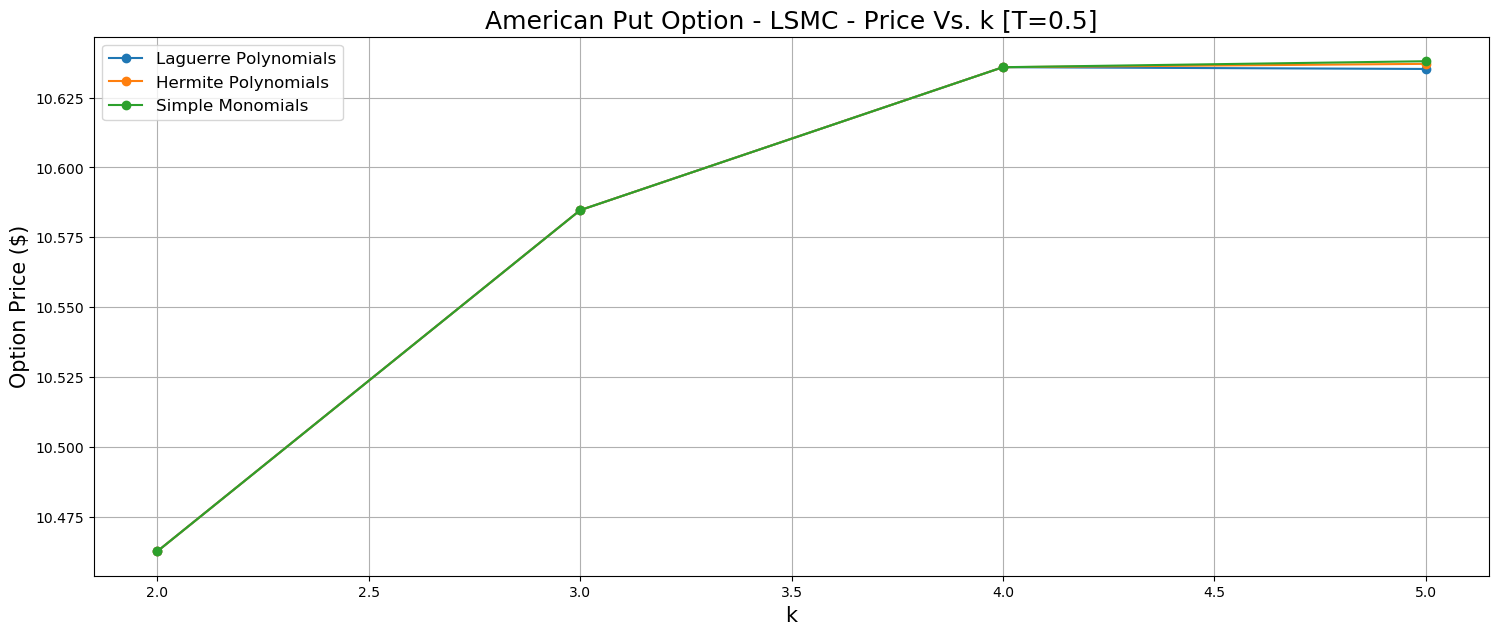

In [37]:
# Plot price Vs. k
plt.figure(figsize=(18, 7))
plt.plot(k_vals, df_q4["Laguerre [T=0.5]"].values, "-o", label="Laguerre Polynomials")
plt.plot(k_vals, df_q4["Hermite [T=0.5]"].values, "-o", label="Hermite Polynomials")
plt.plot(k_vals, df_q4["Simple [T=0.5]"].values, "-o", label="Simple Monomials")
plt.title("American Put Option - LSMC - Price Vs. k [T=0.5]", fontsize=18)
plt.xlabel("k", fontsize=15)
plt.ylabel("Option Price ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

Comment - As we are increasing the value of 'k' option pricing error improves until k = 4 but when k is changed from 4 to 5, the improvment almost stops.

For k = 2-4, all the methods have the same values but for k = 5 the performance order is Simple > Hermite > Laguerre.

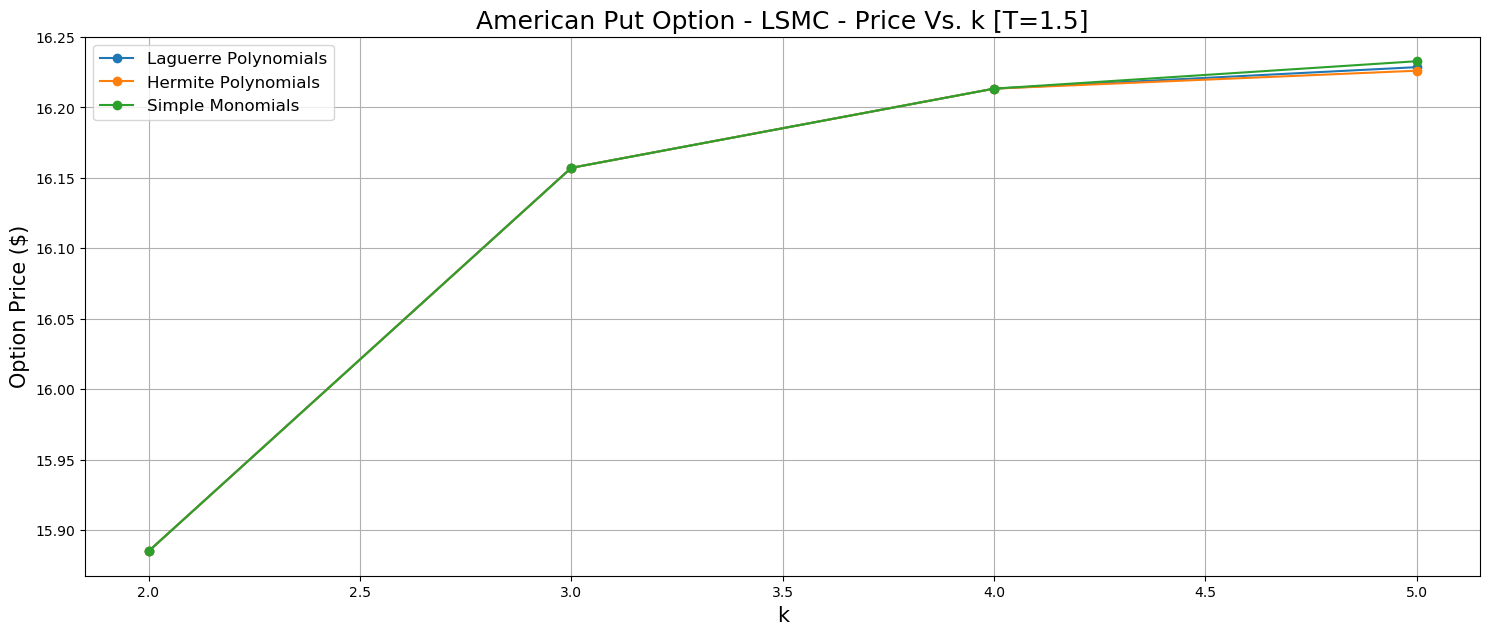

In [38]:
# Plot price Vs. k
plt.figure(figsize=(18, 7))
plt.plot(k_vals, df_q4["Laguerre [T=1.5]"].values, "-o", label="Laguerre Polynomials")
plt.plot(k_vals, df_q4["Hermite [T=1.5]"].values, "-o", label="Hermite Polynomials")
plt.plot(k_vals, df_q4["Simple [T=1.5]"].values, "-o", label="Simple Monomials")
plt.title("American Put Option - LSMC - Price Vs. k [T=1.5]", fontsize=18)
plt.xlabel("k", fontsize=15)
plt.ylabel("Option Price ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

Comment - As stated above, as we are increasing the value of 'k' option pricing error improves until k = 4 but when k is changed from 4 to 5, there is not much improvment and the curve flattens out.

For k = 2-4, all the methods have the same values but for k = 5 the performance order is Simple > Laguerre > Hermite.

Overall, we can say that performance gain for k > 4 is negligible, thus k = 4 is the optimal k value.

## Question 5

In [39]:
N = 100000
seed = 42

S0 = 180
X = 180
r = 5.5/100
T = 0.5
sigma = 25/100
Δt = 0.002

S0_vals = np.arange(170, 191)
ΔX_vals = [sigma*np.sqrt(Δt), sigma*np.sqrt(3*Δt), sigma*np.sqrt(4*Δt)]
ΔX_strs = ["[𝜎√𝛥𝑡]", "[𝜎√3𝛥𝑡]", "[𝜎√4𝛥𝑡]"]

df_q5 = pd.DataFrame()
df_q5["S0"] = S0_vals

**Part a**

In [40]:
def EFD_LogS(S0, X, r, T, sigma, Δt, ΔX):
    # Number of time splits
    M = int(T/Δt)
    # Number of price splits in one direction
    # Choose N such that max stock price is around 3*S0
    N = int(np.log(4)/ΔX)
    
    # Compute Pu, Pm and Pd
    pu = Δt/2*(sigma**2/ΔX**2 + (r-sigma**2/2)/ΔX)
    pm = 1 - Δt*sigma**2/ΔX**2 - r*Δt
    pd = Δt/2*(sigma**2/ΔX**2 - (r-sigma**2/2)/ΔX)
    
    # Compute Stock Prices
    stock_price = np.zeros(2*N+1)
    for j in range(2*N+1):
        log_stock_price = np.log(S0) + ΔX*(N-j)
        stock_price[j] = np.exp(log_stock_price)    
    
    # Create Matirx A
    A = np.diag([pu] + [pm]*(2*N-1) + [pd]) + np.diag([pu]*(2*N-1) + [pm], -1) + np.diag([pm] + [pd]*(2*N-1), 1)
    A[0, 2] = pd
    A[-1, -3] = pu
    
    # Array to store F matirx
    F = np.zeros(2*N+1)
    
    # Array to store B matirx
    B = np.zeros(2*N+1)
    
    # Initialize F with the excercise values at leaves
    for j in range(2*N+1):
        F[j] = max(0, X - stock_price[j])
    
    # Starting with (M-1)th level, iterate each level of the tree until 0th level
    for i in range(M-1, -1, -1):        
        B[2*N] = 0
        B[0] = -(stock_price[0] - stock_price[1])
        F = np.matmul(A, F.T) + B.T
            
    return F[N]

In [41]:
for i in range(len(ΔX_vals)):
    for j in range(len(S0_vals)):
        df_q5.loc[j, "EFD"+ΔX_strs[i]] = EFD_LogS(S0_vals[j], X, r, T, sigma, Δt, ΔX_vals[i])

In [42]:
df_q5

,S0,EFD[𝜎√𝛥𝑡],EFD[𝜎√3𝛥𝑡],EFD[𝜎√4𝛥𝑡]
0,170,14.894088,14.874200,14.889017
1,171,14.365010,14.362273,14.360124
2,172,13.835627,13.850346,13.831231
3,173,13.351476,13.338419,13.346383
4,174,12.873935,12.863105,12.867970
5,175,12.395057,12.394864,12.389558
6,176,11.916090,11.926624,11.911146
7,177,11.487589,11.477964,11.481882
8,178,11.060103,11.053031,11.053607
9,179,10.631214,10.628097,10.625333


**Part b**

In [43]:
def IFD_LogS(S0, X, r, T, sigma, Δt, ΔX):
    # Number of time splits
    M = int(T/Δt)
    # Number of price splits in one direction
    # Choose N such that max stock price is around 3*S0
    N = int(np.log(4)/ΔX)
    
    # Compute Nu, Pu, Pm and Pd
    nu = r - 0.5*sigma**2
    pu = -0.5*Δt*((sigma/ΔX)**2 + nu/ΔX)
    pm = 1.0 + Δt*(sigma/ΔX)**2 + r*Δt
    pd = -0.5*Δt*((sigma/ΔX)**2 - nu/ΔX)
    
    # Compute Stock Prices
    stock_price = np.zeros(2*N+1)
    for j in range(2*N+1):
        log_stock_price = np.log(S0) + ΔX*(N-j)
        stock_price[j] = np.exp(log_stock_price)    
    
    # Create Matirx A
    A = np.diag([1] + [pm]*(2*N-1) + [-1]) + np.diag([pu]*(2*N-1) + [1], -1) + np.diag([-1] + [pd]*(2*N-1), 1)    
    
    # Array to store F matirx
    F = np.zeros(2*N+1)
    
    # Initialize F with the excercise values at leaves
    for j in range(2*N+1):
        F[j] = max(0, X - stock_price[j])
    
    # Starting with (M-1)th level, iterate each level of the tree until 0th level
    for i in range(M-1, -1, -1):
        B = F
        B[2*N] = 0
        B[0] = -(stock_price[0] - stock_price[1])
        F = np.matmul(np.linalg.inv(A), B.T)
            
    return F[N]

In [44]:
for i in range(len(ΔX_vals)):
    for j in range(len(S0_vals)):
        df_q5.loc[j, "IFD"+ΔX_strs[i]] = EFD_LogS(S0_vals[j], X, r, T, sigma, Δt, ΔX_vals[i])

In [45]:
df_q5

,S0,EFD[𝜎√𝛥𝑡],EFD[𝜎√3𝛥𝑡],EFD[𝜎√4𝛥𝑡],IFD[𝜎√𝛥𝑡],IFD[𝜎√3𝛥𝑡],IFD[𝜎√4𝛥𝑡]
0,170,14.894088,14.874200,14.889017,14.894088,14.874200,14.889017
1,171,14.365010,14.362273,14.360124,14.365010,14.362273,14.360124
2,172,13.835627,13.850346,13.831231,13.835627,13.850346,13.831231
3,173,13.351476,13.338419,13.346383,13.351476,13.338419,13.346383
4,174,12.873935,12.863105,12.867970,12.873935,12.863105,12.867970
5,175,12.395057,12.394864,12.389558,12.395057,12.394864,12.389558
6,176,11.916090,11.926624,11.911146,11.916090,11.926624,11.911146
7,177,11.487589,11.477964,11.481882,11.487589,11.477964,11.481882
8,178,11.060103,11.053031,11.053607,11.060103,11.053031,11.053607
9,179,10.631214,10.628097,10.625333,10.631214,10.628097,10.625333


**Part c**

In [46]:
def CNFD_LogS(S0, X, r, T, sigma, Δt, ΔX):
    # Number of time splits
    M = int(T/Δt)
    # Number of price splits in one direction
    # Choose N such that max stock price is around 3*S0
    N = int(np.log(4)/ΔX)
    
    # Compute Nu, Pu, Pm and Pd
    nu = r - 0.5*sigma**2
    pu = -0.25*Δt*((sigma/ΔX)**2 + nu/ΔX)
    pm = 1.0 + 0.5*Δt*(sigma/ΔX)**2 + 0.5*r*Δt
    pd = -0.25*Δt*((sigma/ΔX)**2 - nu/ΔX)
    
    # Compute Stock Prices
    stock_price = np.zeros(2*N+1)
    for j in range(2*N+1):
        log_stock_price = np.log(S0) + ΔX*(N-j)
        stock_price[j] = np.exp(log_stock_price)
    
    # Create Matirx A
    A = np.diag([1] + [pm]*(2*N-1) + [-1]) + np.diag([pu]*(2*N-1) + [1], -1) + np.diag([-1] + [pd]*(2*N-1), 1)    
    
    # Array to store F matirx
    F = np.zeros(2*N+1)
    
    # Array to store Z matirx
    Z = np.zeros(2*N+1)
    
    # Initialize F with the excercise values at leaves
    for j in range(2*N+1):
        F[j] = max(0, X - stock_price[j])
    
    # Starting with (M-1)th level, iterate each level of the tree until 0th level
    for i in range(M-1, -1, -1):
        for j in range(1, 2*N-1):
            Z[j] = -Pu*F[j+1] - (Pm-2)*F[j] - Pd*F[j-1]    
        Z[2*N] = 0
        Z[0] = -(stock_price[0] - stock_price[1])
        F = np.matmul(np.linalg.inv(A), Z.T)
            
    return F[N]

In [47]:
for i in range(len(ΔX_vals)):
    for j in range(len(S0_vals)):
        df_q5.loc[j, "CNFD"+ΔX_strs[i]] = EFD_LogS(S0_vals[j], X, r, T, sigma, Δt, ΔX_vals[i])

In [48]:
df_q5

,S0,EFD[𝜎√𝛥𝑡],EFD[𝜎√3𝛥𝑡],EFD[𝜎√4𝛥𝑡],IFD[𝜎√𝛥𝑡],IFD[𝜎√3𝛥𝑡],IFD[𝜎√4𝛥𝑡],CNFD[𝜎√𝛥𝑡],CNFD[𝜎√3𝛥𝑡],CNFD[𝜎√4𝛥𝑡]
0,170,14.894088,14.874200,14.889017,14.894088,14.874200,14.889017,14.894088,14.874200,14.889017
1,171,14.365010,14.362273,14.360124,14.365010,14.362273,14.360124,14.365010,14.362273,14.360124
2,172,13.835627,13.850346,13.831231,13.835627,13.850346,13.831231,13.835627,13.850346,13.831231
3,173,13.351476,13.338419,13.346383,13.351476,13.338419,13.346383,13.351476,13.338419,13.346383
4,174,12.873935,12.863105,12.867970,12.873935,12.863105,12.867970,12.873935,12.863105,12.867970
5,175,12.395057,12.394864,12.389558,12.395057,12.394864,12.389558,12.395057,12.394864,12.389558
6,176,11.916090,11.926624,11.911146,11.916090,11.926624,11.911146,11.916090,11.926624,11.911146
7,177,11.487589,11.477964,11.481882,11.487589,11.477964,11.481882,11.487589,11.477964,11.481882
8,178,11.060103,11.053031,11.053607,11.060103,11.053031,11.053607,11.060103,11.053031,11.053607
9,179,10.631214,10.628097,10.625333,10.631214,10.628097,10.625333,10.631214,10.628097,10.625333


In [49]:
for j in range(len(S0_vals)):
        df_q5.loc[j, "TTAP"] = TTAP_3b(S0_vals[j], X, r, T, sigma, 500)

In [50]:
df_q5

,S0,EFD[𝜎√𝛥𝑡],EFD[𝜎√3𝛥𝑡],EFD[𝜎√4𝛥𝑡],IFD[𝜎√𝛥𝑡],IFD[𝜎√3𝛥𝑡],IFD[𝜎√4𝛥𝑡],CNFD[𝜎√𝛥𝑡],CNFD[𝜎√3𝛥𝑡],CNFD[𝜎√4𝛥𝑡],TTAP
0,170,14.894088,14.874200,14.889017,14.894088,14.874200,14.889017,14.894088,14.874200,14.889017,15.685194
1,171,14.365010,14.362273,14.360124,14.365010,14.362273,14.360124,14.365010,14.362273,14.360124,15.119045
2,172,13.835627,13.850346,13.831231,13.835627,13.850346,13.831231,13.835627,13.850346,13.831231,14.568337
3,173,13.351476,13.338419,13.346383,13.351476,13.338419,13.346383,13.351476,13.338419,13.346383,14.028223
4,174,12.873935,12.863105,12.867970,12.873935,12.863105,12.867970,12.873935,12.863105,12.867970,13.510669
5,175,12.395057,12.394864,12.389558,12.395057,12.394864,12.389558,12.395057,12.394864,12.389558,12.998641
6,176,11.916090,11.926624,11.911146,11.916090,11.926624,11.911146,11.916090,11.926624,11.911146,12.510507
7,177,11.487589,11.477964,11.481882,11.487589,11.477964,11.481882,11.487589,11.477964,11.481882,12.031199
8,178,11.060103,11.053031,11.053607,11.060103,11.053031,11.053607,11.060103,11.053031,11.053607,11.566073
9,179,10.631214,10.628097,10.625333,10.631214,10.628097,10.625333,10.631214,10.628097,10.625333,11.118827


In [51]:
df_q5_errors = df_q5.iloc[:, 1:-1].sub(df_q5["TTAP"], axis=0)
df_q5_errors

,EFD[𝜎√𝛥𝑡],EFD[𝜎√3𝛥𝑡],EFD[𝜎√4𝛥𝑡],IFD[𝜎√𝛥𝑡],IFD[𝜎√3𝛥𝑡],IFD[𝜎√4𝛥𝑡],CNFD[𝜎√𝛥𝑡],CNFD[𝜎√3𝛥𝑡],CNFD[𝜎√4𝛥𝑡]
0,-0.791106,-0.810994,-0.796177,-0.791106,-0.810994,-0.796177,-0.791106,-0.810994,-0.796177
1,-0.754035,-0.756772,-0.758921,-0.754035,-0.756772,-0.758921,-0.754035,-0.756772,-0.758921
2,-0.732710,-0.717991,-0.737106,-0.732710,-0.717991,-0.737106,-0.732710,-0.717991,-0.737106
3,-0.676747,-0.689804,-0.681840,-0.676747,-0.689804,-0.681840,-0.676747,-0.689804,-0.681840
4,-0.636734,-0.647564,-0.642698,-0.636734,-0.647564,-0.642698,-0.636734,-0.647564,-0.642698
5,-0.603584,-0.603777,-0.609083,-0.603584,-0.603777,-0.609083,-0.603584,-0.603777,-0.609083
6,-0.594417,-0.583884,-0.599362,-0.594417,-0.583884,-0.599362,-0.594417,-0.583884,-0.599362
7,-0.543610,-0.553235,-0.549317,-0.543610,-0.553235,-0.549317,-0.543610,-0.553235,-0.549317
8,-0.505970,-0.513042,-0.512465,-0.505970,-0.513042,-0.512465,-0.505970,-0.513042,-0.512465
9,-0.487613,-0.490730,-0.493493,-0.487613,-0.490730,-0.493493,-0.487613,-0.490730,-0.493493


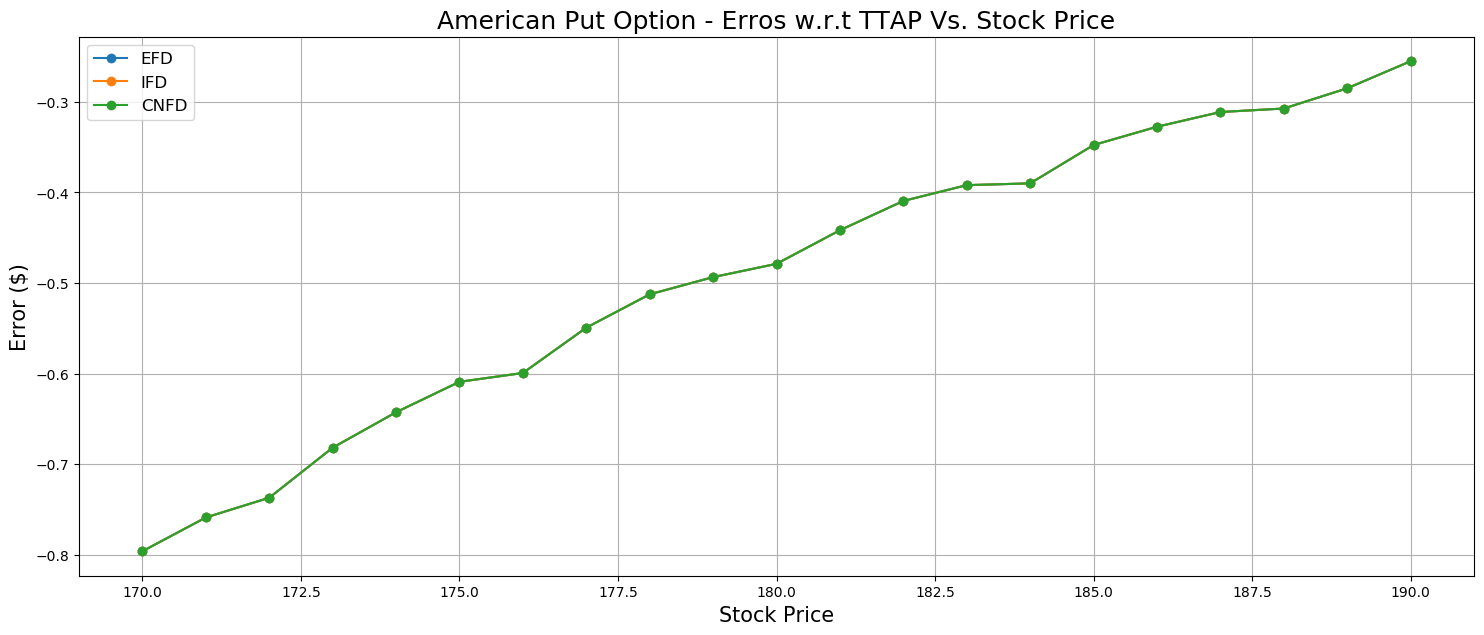

In [56]:
# Plot price Vs. k
plt.figure(figsize=(18, 7))
plt.plot(S0_vals, df_q5_errors.iloc[:, 2].values, "-o", label="EFD")
plt.plot(S0_vals, df_q5_errors.iloc[:, 5].values, "-o", label="IFD")
plt.plot(S0_vals, df_q5_errors.iloc[:, 8].values, "-o", label="CNFD")
plt.title("American Put Option - Erros w.r.t TTAP Vs. Stock Price", fontsize=18)
plt.xlabel("Stock Price", fontsize=15)
plt.ylabel("Error ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

Comment - The errors are very close to each other, there is no observable difference.

## Question 6

In [53]:
def EFD_S(S0, X, r, T, sigma, Δt, ΔS):
    # Number of time splits
    M = int(T/Δt)
    # Number of price splits in one direction
    N = int(2*S0/ΔS)
    #print(M, N)
    # Compute Pu, Pm and Pd, Note that value at index 0 is redundant and never used
    pu = np.zeros(N)
    pm = np.zeros(N)
    pd = np.zeros(N)
    for j in range(1, N):
        pu[j] = 0.5*Δt*(r*j + sigma**2*j**2)
        pm[j]  = 1 - Δt*(sigma**2*j**2 + r)
        pd[j] = 0.5*Δt*(-r*j + sigma**2*j**2)
    
    # Compute Stock Prices
    stock_price = np.zeros(N+1)
    for j in range(N+1):
        stock_price[j] = S0 + (N-j)*ΔS
    
    # Create Matirx A
    A = np.diag([pu[N-1]] + list(pm[:0:-1]) + [pd[1]]) + \
        np.diag(list(pu[:0:-1]) + [pm[1]], -1) + \
        np.diag([pm[N-1]] + list(pd[:0:-1]), 1)
    A[0, 2] = pd[N-1]
    A[-1, -3] = pu[1]
    
    # Array to store F matirx
    F = np.zeros(N+1)
    
    # Array to store B matirx
    B = np.zeros(N+1)
    
    # Initialize F with the excercise values at leaves
    for j in range(N+1):
        F[j] = max(0, X - stock_price[j])
    
    # Starting with (M-1)th level, iterate each level of the tree until 0th level
    for i in range(M-1, -1, -1):        
        B[N] = 0
        B[0] = -(stock_price[0] - stock_price[1])
        F = np.matmul(A, F.T) + B.T
            
    return F[N]

In [54]:
S0 = 180
X = 180
r = 5.5/100
T = 0.5
sigma = 25/100

Δt = 0.002
ΔS = 0.5

S0_vals = np.arange(170, 191)

df_q6 = pd.DataFrame(index=S0_vals)

In [ ]:
for S0_ in S0_vals:
    df_q6.loc[S0_, "EFD"] = EFD_S(S0_, X, r, T, sigma, Δt, ΔS)